In [1]:
from __future__ import annotations
from typing import Protocol, runtime_checkable, Iterable, Optional, Union, List, Tuple
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt


## CME 193 — Scientific Python
### Week 2: Object-Oriented Programming (OOP)

- Learning objectives:
  - Translate core OOP ideas to scientific Python
  - Build a reusable `UnivariateOLS` model for linear regression
  - Practice encapsulation, instance methods, and special methods

## Agenda

In this mini‑session, you’ll learn core OOP ideas in Python by building a tiny linear regression model and progressively adding features.

- What is Univariate Ordinary Least Squares (OLS)? Quick statistical primer.

- Defining a class and `__init__` (encapsulation).

- Instance methods (`fit`).

- Using internal state (`predict`).

- Quality metric (`score`), docstrings, type hints.

- Magic/dunder methods: `__str__` / `__repr__`

- Optional: Streaming OLS + operator overloading (`__iadd__`, `__add__`)

## Part 0 — Primer: Univariate OLS

- Model: $y = \beta_0 + \beta_1 x + \varepsilon$
- Goal: choose $\beta_0, \beta_1$ to minimize squared errors

### Simulated data generating process

We'll create synthetic data following a simple linear relationship with noise:

$y = \beta_0 + \beta_1 x + \varepsilon$

- $x$: uniformly spaced from 0 to 10 (50 points)
- $\beta_0 = 10.0$, $\beta_1 = 2.5$
- $\varepsilon \sim \mathcal{N}(0, 1.5)$

Goal: estimate $\beta_0, \beta_1$ from data via OLS.

In [2]:
# Fix the random seed for reproducibility.
np.random.seed(42)
# Number of N points.
n_points = 50
# Generate x values from 0 to 10.
x = np.linspace(0, 10, n_points)
# Define the true slope and intercept.
true_slope = 2.5
true_intercept = 10.0
# Generate noise.
noise = np.random.normal(0, 1.5, n_points)
# Generate y values.
y = true_intercept + true_slope * x + noise

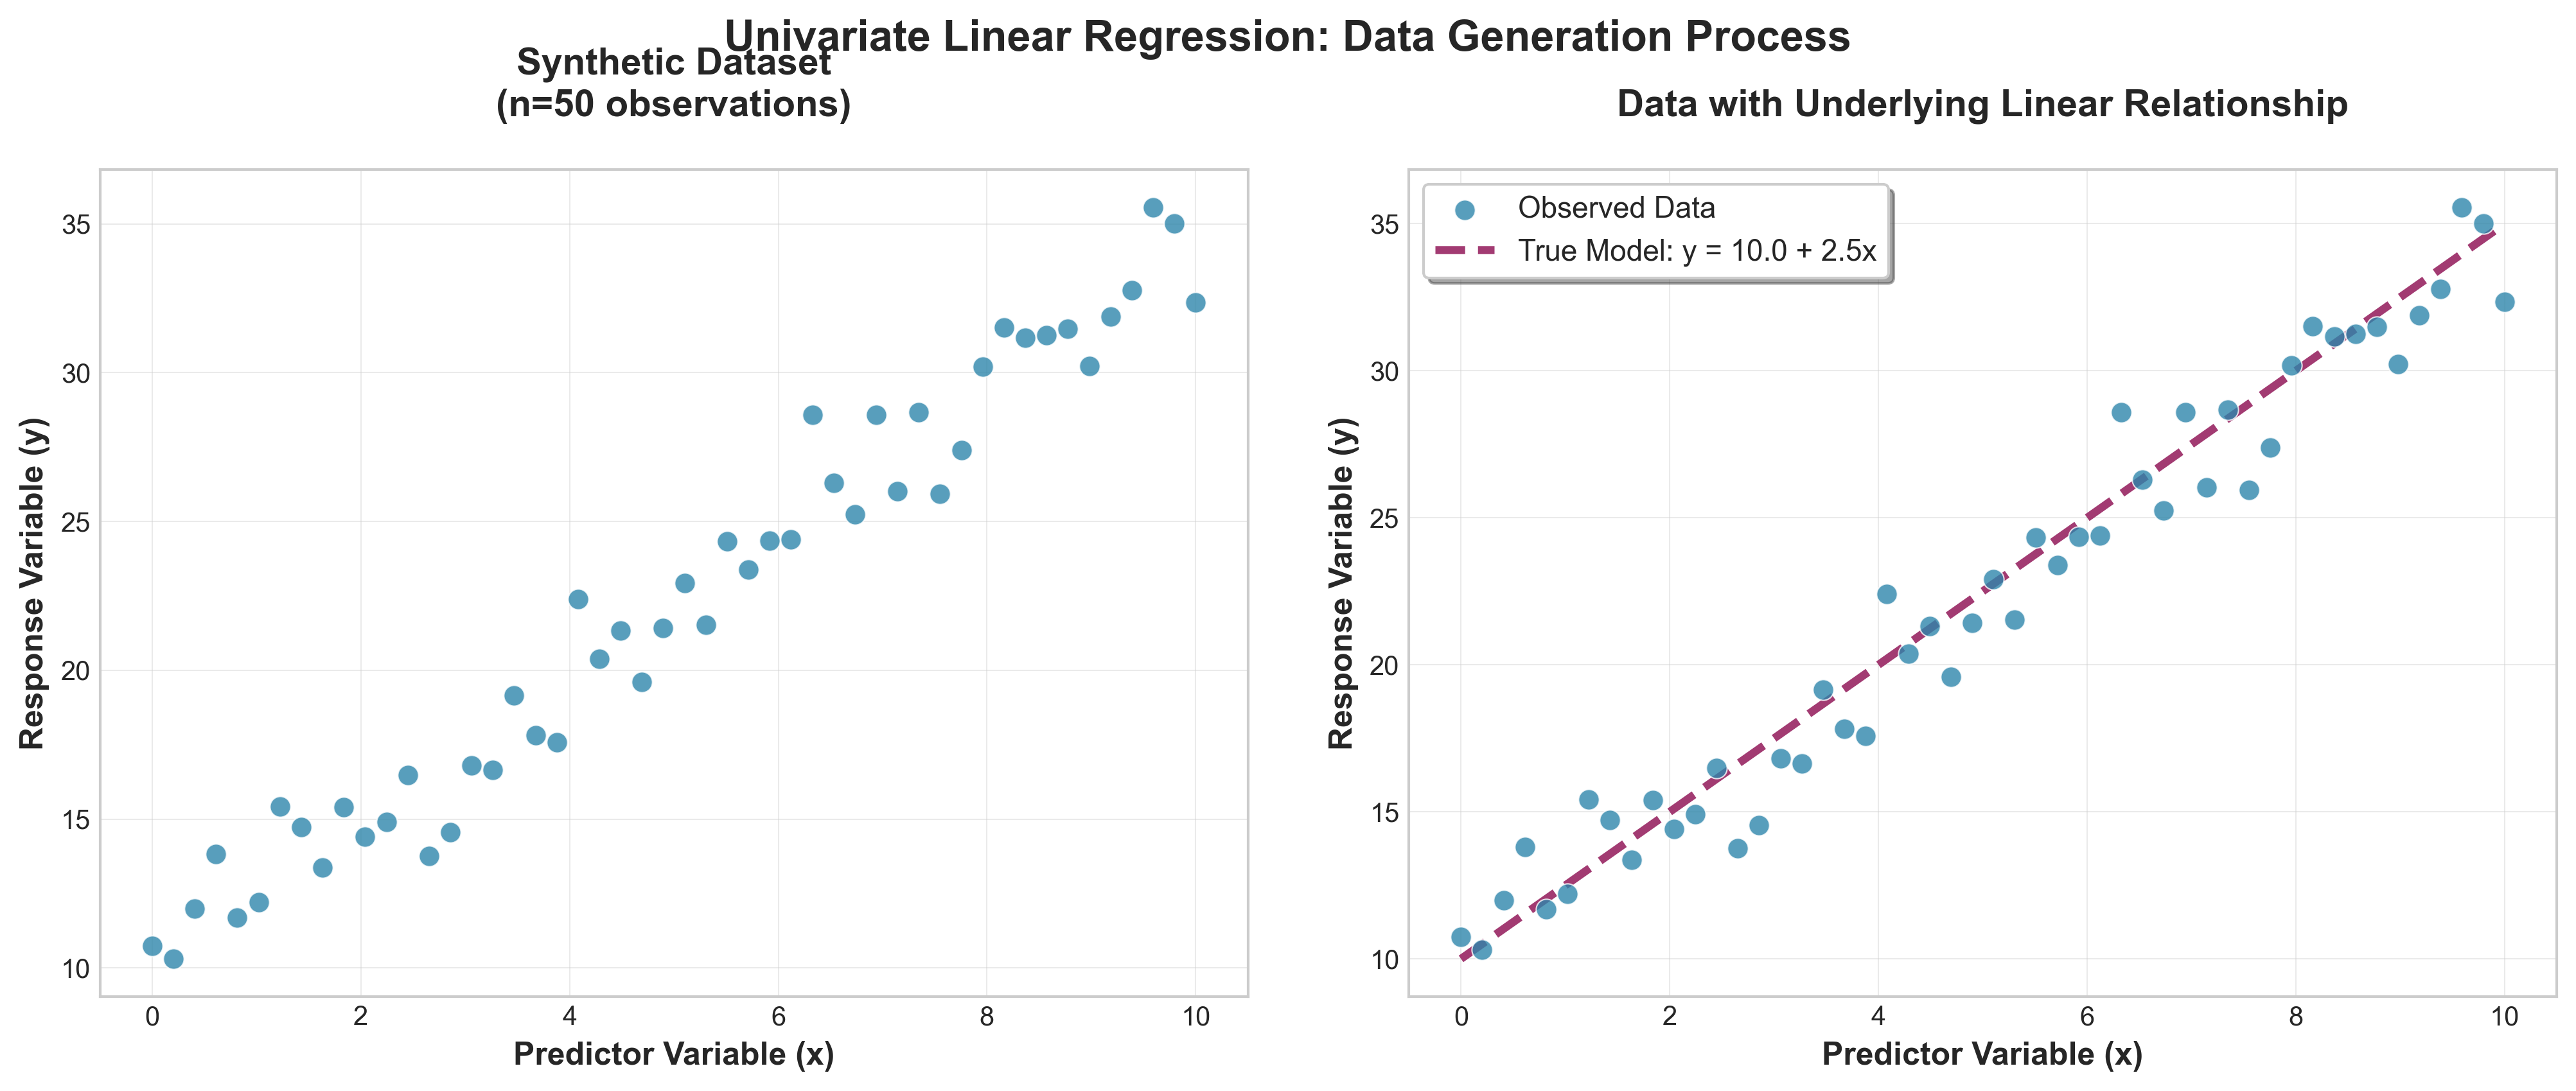

                  DATA GENERATION SUMMARY                   
Parameter                 Value           Description
------------------------------------------------------------
Sample Size (n)           50              Number of observations
X Range                   [0.0, 10.0]     Predictor variable range
Y Range                   [10.3, 35.6]    Response variable range
True Intercept (β₀)       10.0            Population parameter
True Slope (β₁)           2.5             Population parameter
Noise Std Dev (σ)         1.39            Error term variability
R² (theoretical)          0.963           Expected explained variance


In [3]:
# Professional visualization of synthetic data
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

# Plot 1: Raw data points with enhanced styling
axes[0].scatter(x, y, alpha=0.8, color='#2E86AB', s=60, edgecolors='white', linewidth=0.5)
axes[0].set_xlabel('Predictor Variable (x)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Response Variable (y)', fontsize=12, fontweight='bold')
axes[0].set_title('Synthetic Dataset\n(n=50 observations)', fontsize=14, fontweight='bold', pad=20)
axes[0].grid(True, alpha=0.4, linestyle='-', linewidth=0.5)
axes[0].tick_params(axis='both', which='major', labelsize=10)

# Plot 2: Data with true relationship line
axes[1].scatter(x, y, alpha=0.8, color='#2E86AB', s=60, edgecolors='white',
                linewidth=0.5, label='Observed Data', zorder=3)
y_true = true_intercept + true_slope * x
axes[1].plot(x, y_true, color='#A23B72', linewidth=3, linestyle='--',
             label=f'True Model: y = {true_intercept:.1f} + {true_slope:.1f}x', zorder=2)
axes[1].set_xlabel('Predictor Variable (x)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Response Variable (y)', fontsize=12, fontweight='bold')
axes[1].set_title('Data with Underlying Linear Relationship', fontsize=14, fontweight='bold', pad=20)
axes[1].legend(loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=11)
axes[1].grid(True, alpha=0.4, linestyle='-', linewidth=0.5)
axes[1].tick_params(axis='both', which='major', labelsize=10)

# Enhance overall figure appearance
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.85)
fig.suptitle('Univariate Linear Regression: Data Generation Process',
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

# Professional data summary table
print("=" * 60)
print("DATA GENERATION SUMMARY".center(60))
print("=" * 60)
print(f"{'Parameter':<25} {'Value':<15} {'Description'}")
print("-" * 60)
print(f"{'Sample Size (n)':<25} {n_points:<15} {'Number of observations'}")
print(f"{'X Range':<25} {f'[{x.min():.1f}, {x.max():.1f}]':<15} {'Predictor variable range'}")
print(f"{'Y Range':<25} {f'[{y.min():.1f}, {y.max():.1f}]':<15} {'Response variable range'}")
print(f"{'True Intercept (β₀)':<25} {true_intercept:<15} {'Population parameter'}")
print(f"{'True Slope (β₁)':<25} {true_slope:<15} {'Population parameter'}")
print(f"{'Noise Std Dev (σ)':<25} {f'{noise.std():.2f}':<15} {'Error term variability'}")
print(f"{'R² (theoretical)':<25} {f'{1 - (noise.var() / y.var()):.3f}':<15} {'Expected explained variance'}")
print("=" * 60)

## OLS: mathematical foundation

- **Linear model**: $y = \beta_0 + \beta_1 x + \varepsilon$
- **Objective**: minimize $\sum_{i=1}^{n} (y_i - \beta_0 - \beta_1 x_i)^2$
- **Notation**:
  - $S_x = \sum x_i$, $S_y = \sum y_i$
  - $S_{xy} = \sum x_i y_i$, $S_{xx} = \sum x_i^2$
- **Closed form**:
  - $\hat{\beta}_1 = \frac{n S_{xy} - S_x S_y}{n S_{xx} - S_x^2}$
  - $\hat{\beta}_0 = \frac{S_y - \hat{\beta}_1 S_x}{n}$
- **No-intercept case**: $\hat{\beta}_1 = \frac{S_{xy}}{S_{xx}}$

## Implementation: closed-form OLS (script)

In [4]:
# Compute OLS coefficients manually (for illustration)
n = len(x)
Sxy = np.sum(x * y)
Sxx = np.sum(x**2)
Sx = np.sum(x)
Sy = np.sum(y)
slope = (n * Sxy - Sx * Sy) / (n * Sxx - Sx**2)
intercept = (Sy - slope * Sx) / n

slope_without_intercept = Sxy / Sxx

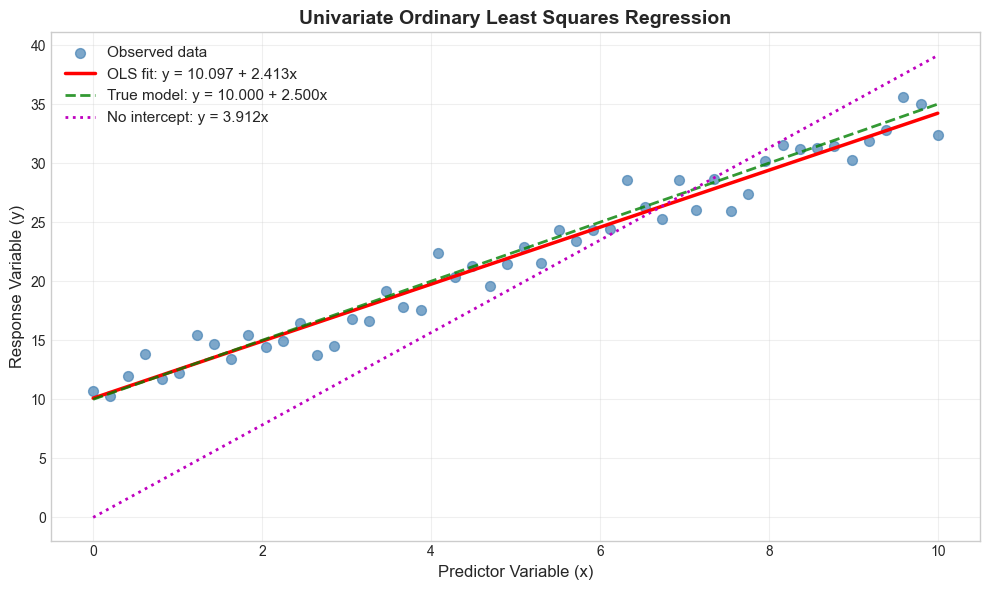

Parameter Estimation Results:
True parameters:      β₀ = 10.000, β₁ =  2.500
OLS estimates:        β̂₀ = 10.097, β̂₁ =  2.413
No-intercept slope:   β̂₁ =  3.912
Estimation errors:    Δβ₀ =  0.097, Δβ₁ = -0.087


In [5]:
# Generate fitted line for visualization
x_line = np.linspace(x.min(), x.max(), 100)
y_line = intercept + slope * x_line
y_line_no_intercept = slope_without_intercept * x_line

# Create comprehensive visualization
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, color='steelblue', s=50, label='Observed data')
plt.plot(x_line, y_line, 'r-', linewidth=2.5,
         label=f'OLS fit: y = {intercept:.3f} + {slope:.3f}x')

# Add true regression line for comparison
y_true_line = true_intercept + true_slope * x_line
plt.plot(x_line, y_true_line, 'g--', linewidth=2, alpha=0.8,
         label=f'True model: y = {true_intercept:.3f} + {true_slope:.3f}x')

# Add slope without intercept line
plt.plot(x_line, y_line_no_intercept, 'm:', linewidth=2,
         label=f'No intercept: y = {slope_without_intercept:.3f}x')

plt.xlabel('Predictor Variable (x)', fontsize=12)
plt.ylabel('Response Variable (y)', fontsize=12)
plt.title('Univariate Ordinary Least Squares Regression', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display parameter comparison
print("Parameter Estimation Results:")
print("=" * 40)
print(f"True parameters:      β₀ = {true_intercept:6.3f}, β₁ = {true_slope:6.3f}")
print(f"OLS estimates:        β̂₀ = {intercept:6.3f}, β̂₁ = {slope:6.3f}")
print(f"No-intercept slope:   β̂₁ = {slope_without_intercept:6.3f}")
print(f"Estimation errors:    Δβ₀ = {intercept - true_intercept:6.3f}, Δβ₁ = {slope - true_slope:6.3f}")

## From formulas to a reusable class

- Re-using ad-hoc code is cumbersome
- Encapsulate data and behavior in an `UnivariateOLS` object

## Part 1 — Encapsulation and constructor `__init__`

- Bundle data (attributes) and behavior (methods)
- Initialize instance state in `__init__`
- Store training data and configuration on `self`

Try: instantiate `UnivariateOLS(...)` and inspect `model.fit_intercept`. 

In [6]:
x_data = x.tolist()
y_data = y.tolist()
print(f"{x_data=:}")
print(f"{y_data=:}")

x_data=[0.0, 0.20408163265306123, 0.40816326530612246, 0.6122448979591837, 0.8163265306122449, 1.0204081632653061, 1.2244897959183674, 1.4285714285714286, 1.6326530612244898, 1.836734693877551, 2.0408163265306123, 2.2448979591836737, 2.4489795918367347, 2.6530612244897958, 2.857142857142857, 3.0612244897959187, 3.2653061224489797, 3.4693877551020407, 3.673469387755102, 3.8775510204081636, 4.081632653061225, 4.285714285714286, 4.4897959183673475, 4.6938775510204085, 4.8979591836734695, 5.1020408163265305, 5.3061224489795915, 5.510204081632653, 5.714285714285714, 5.918367346938775, 6.122448979591837, 6.326530612244898, 6.530612244897959, 6.73469387755102, 6.938775510204081, 7.142857142857143, 7.346938775510204, 7.551020408163265, 7.755102040816327, 7.959183673469388, 8.16326530612245, 8.36734693877551, 8.571428571428571, 8.775510204081632, 8.979591836734695, 9.183673469387756, 9.387755102040817, 9.591836734693878, 9.795918367346939, 10.0]
y_data=[10.74507122951685, 10.302807629875876, 11

In [7]:
class UnivariateOLS:  # we start with the simplest model, with class ModelName.
    def __init__(self, x_data: List[float], y_data: List[float], fit_intercept: bool):
        # This is the constructor (if you are familiar with C++).
        # Initialize the model with the fit_intercept parameter, whether we want to fit the intercept.
        # The self points to the instance of this class.
        self.fit_intercept = bool(fit_intercept)
        # Store the training data (X, y) to the instance.
        self.x_data = deepcopy(x_data)
        self.y_data = deepcopy(y_data)
        # Store the intercept and slope fitted, initialized to None because we haven't fitted the model yet!
        self.intercept = None
        self.slope = None

### Create an instance

- Instantiates the class and invokes `__init__` with the provided arguments.

In [8]:
model = UnivariateOLS(x_data=x, y_data=y, fit_intercept=True)
# This isn't very informative, it shows the class name and the memory address of the object.
# we will fix this later by defining the `__repr__` method.
model

In [9]:
# We have passed in a few data and a boolean flag to the model.
print(f"{model.fit_intercept=:}")
print(f"{model.x_data=:}")
print(f"{model.y_data=:}")

model.fit_intercept=True
model.x_data=[ 0.          0.20408163  0.40816327  0.6122449   0.81632653  1.02040816
  1.2244898   1.42857143  1.63265306  1.83673469  2.04081633  2.24489796
  2.44897959  2.65306122  2.85714286  3.06122449  3.26530612  3.46938776
  3.67346939  3.87755102  4.08163265  4.28571429  4.48979592  4.69387755
  4.89795918  5.10204082  5.30612245  5.51020408  5.71428571  5.91836735
  6.12244898  6.32653061  6.53061224  6.73469388  6.93877551  7.14285714
  7.34693878  7.55102041  7.75510204  7.95918367  8.16326531  8.36734694
  8.57142857  8.7755102   8.97959184  9.18367347  9.3877551   9.59183673
  9.79591837 10.        ]
model.y_data=[10.74507123 10.30280763 11.99194097 13.81515703 11.68958626 12.19981497
 15.43004371 14.72258067 13.37742107 15.4056768  14.40691428 14.91365027
 16.48539239 13.76273269 14.55548039 16.80962993 16.64401863 19.14484039
 17.82163736 17.575422   22.40255479 20.37562126 21.3257821  19.5975716
 21.42832387 22.92148593 21.53881576 24.33905723

In [10]:
# However, we haven't fitted the model yet, so the intercept and slope are None.
print(f"{model.intercept=:}")
print(f"{model.slope=:}")

model.intercept=None
model.slope=None


## Part 2 — Instance method `fit` (behavior on state)

- Let's now define our first method (apart from the constructor) in this `UnivariateOLS` class.

- Instance methods always take `self` as the first parameter, so that it can refer to other information stored in the instance (e.g., `self.x_data` and `self.y_data`).

- Methods can read/modify attributes stored on `self`.

- We implement `fit(X, y)` using the closed form solution to OLS.

In [11]:
class UnivariateOLS:  # we start with the simplest model, with class ModelName.
    def __init__(self, x_data: List[float], y_data: List[float], fit_intercept: bool):
        # This is the constructor (if you are familiar with C++).
        # Initialize the model with the fit_intercept parameter, whether we want to fit the intercept.
        # The self points to the instance of this class.
        self.fit_intercept = bool(fit_intercept)
        # Store the training data (X, y) to the instance.
        self.x_data = deepcopy(x_data)
        self.y_data = deepcopy(y_data)
        # Store the intercept and slope fitted, initialized to None because we haven't fitted the model yet!
        self.intercept = None
        self.slope = None

    # ==================================================================================================================
    # Everything above is the same as the previous version.
    # ==================================================================================================================
    def fit(self):
        # The method inside the class can READ other attributes stored on this instance via the `self`.
        # For example, `self.x_data` and `self.y_data` are the training data.
        # Again, it is always good to check for potential data errors before you do the computation.
        if len(self.x_data) != len(self.y_data):
            raise ValueError("X and y must have same length")

        # get the length of the training data.
        n = len(self.x_data)

        # Get the sum of the training x and training y, we need them to compute the slope and intercept.
        Sx = sum(self.x_data)
        Sy = sum(self.y_data)

        # Also the sum of square of x and the sum of x and y.
        Sxx = 0
        # you can loop over lists using for item in list.
        for x in self.x_data:
            Sxx += x * x

        # Also the sum of x and y.
        Sxy = 0
        # you can loop over lists using index i.
        for i in range(n):  # (0, 1, 2, ..., n-1).
            Sxy += self.x_data[i] * self.y_data[i]

        # You can choose to report some information, which can be helpful for debugging.
        print(f"Training data: n={n}, Sx={Sx}, Sy={Sy}, Sxx={Sxx}, Sxy={Sxy}")

        # Here we got two options!
        if self.fit_intercept:
            # The denominator of the slope.
            den = n * Sxx - Sx * Sx
            # If the denominator is zero, it means all x are identical, which is not a good thing.
            # We raise the error here.
            if den == 0:
                raise ZeroDivisionError("Denominator is zero (all x identical?).")
            # The slope.
            self.slope = float((n * Sxy - Sx * Sy) / den)
            # The intercept.
            self.intercept = float((Sy - self.slope * Sx) / n)
            print(f"Model intercept and slope have been fitted successfully.")
        else:
            if Sxx == 0:
                raise ZeroDivisionError("Sxx is zero (all x are zero?).")
            self.slope = float(Sxy / Sxx)
            # we do not touch the intercept here, it remains None.
            print(f"Model slope has been fitted successfully.")

In [12]:
# Let's now fit the first model (with intercept).
model_with_intercept = UnivariateOLS(x_data=x, y_data=y, fit_intercept=True)
model_with_intercept.fit()

Training data: n=50, Sx=250.0, Sy=1108.0894571057895, Sxx=1683.6734693877552, Sxy=6586.912165961563
Model intercept and slope have been fitted successfully.


In [13]:
# One can access the attributes of the instance via the dot notation.
print(f"{model_with_intercept.slope=:}")
print(f"{model_with_intercept.intercept=:}")

# These are pretty close to the ground truth!

model_with_intercept.slope=2.4130249007622675
model_with_intercept.intercept=10.096664638304453


In [14]:
# Let's now fit the second model (without intercept).
model_without_intercept = UnivariateOLS(x_data=x, y_data=y, fit_intercept=False)
model_without_intercept.fit()
print(f"{model_without_intercept.slope=:}")
print(f"{model_without_intercept.intercept=:}")  # the intercept remains None because we did not fit the intercept.

Training data: n=50, Sx=250.0, Sy=1108.0894571057895, Sxx=1683.6734693877552, Sxy=6586.912165961563
Model slope has been fitted successfully.
model_without_intercept.slope=3.9122266197832314
model_without_intercept.intercept=None


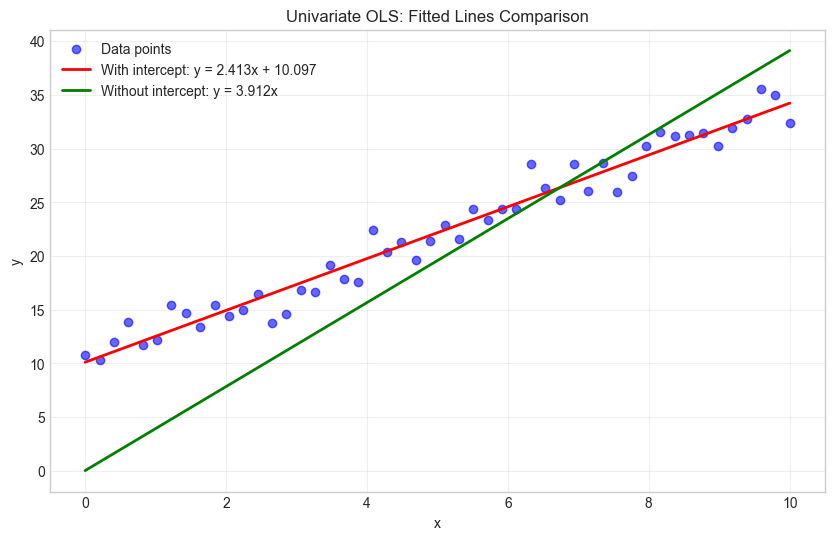

In [15]:
# Let's visualize both models with the original data
plt.figure(figsize=(10, 6))

# Plot the original data points
plt.scatter(x, y, alpha=0.6, color='blue', label='Data points')

# Create x values for plotting the fitted lines
x_plot = np.linspace(min(x), max(x), 100)

# Plot the model with intercept
y_with_intercept = model_with_intercept.slope * x_plot + model_with_intercept.intercept
plt.plot(x_plot, y_with_intercept, 'red', linewidth=2,
         label=f'With intercept: y = {model_with_intercept.slope:.3f}x + {model_with_intercept.intercept:.3f}')

# Plot the model without intercept
y_without_intercept = model_without_intercept.slope * x_plot
plt.plot(x_plot, y_without_intercept, 'green', linewidth=2,
         label=f'Without intercept: y = {model_without_intercept.slope:.3f}x')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Univariate OLS: Fitted Lines Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Part 3 — Predict on new data

- After `fit`, use `self.intercept` and `self.slope` to compute predictions
- We can also use `self.intercept` and `self.slope` in the `predict` method.

In [16]:
class UnivariateOLS:  # we start with the simplest model, with class ModelName.
    def __init__(self, x_data: List[float], y_data: List[float], fit_intercept: bool):
        # This is the constructor (if you are familiar with C++).
        # Initialize the model with the fit_intercept parameter, whether we want to fit the intercept.
        # The self points to the instance of this class.
        self.fit_intercept = bool(fit_intercept)
        # Store the training data (X, y) to the instance.
        self.x_data = deepcopy(x_data)
        self.y_data = deepcopy(y_data)
        # Store the intercept and slope fitted, initialized to None because we haven't fitted the model yet!
        self.intercept = None
        self.slope = None

    # the new fit method.
    def fit(self):
        # The method inside the class can READ other attributes stored on this instance via the `self`.
        # For example, `self.x_data` and `self.y_data` are the training data.
        # Again, it is always good to check for potential data errors before you do the computation.
        if len(self.x_data) != len(self.y_data):
            raise ValueError("X and y must have same length")

        # get the length of the training data.
        n = len(self.x_data)

        # Get the sum of the training x and training y, we need them to compute the slope and intercept.
        Sx = sum(self.x_data)
        Sy = sum(self.y_data)

        # Also the sum of square of x and the sum of x and y.
        Sxx = 0
        # you can loop over lists using for item in list.
        for x in self.x_data:
            Sxx += x * x

        # Also the sum of x and y.
        Sxy = 0
        # you can loop over lists using index i.
        for i in range(n):  # (0, 1, 2, ..., n-1).
            Sxy += self.x_data[i] * self.y_data[i]

        # You can choose to report some information, which can be helpful for debugging.
        print(f"Training data: n={n}, Sx={Sx}, Sy={Sy}, Sxx={Sxx}, Sxy={Sxy}")

        # Here we got two options!
        if self.fit_intercept:
            # The denominator of the slope.
            den = n * Sxx - Sx * Sx
            # If the denominator is zero, it means all x are identical, which is not a good thing.
            # We raise the error here.
            if den == 0:
                raise ZeroDivisionError("Denominator is zero (all x identical?).")
            # The slope.
            self.slope = float((n * Sxy - Sx * Sy) / den)
            # The intercept.
            self.intercept = float((Sy - self.slope * Sx) / n)
            print(f"Model intercept and slope have been fitted successfully.")
        else:
            if Sxx == 0:
                raise ZeroDivisionError("Sxx is zero (all x are zero?).")
            self.slope = float(Sxy / Sxx)
            # we do not touch the intercept here, it remains None.
            print(f"Model slope has been fitted successfully.")

    # ==================================================================================================================
    # Everything above is the same as the previous version.
    # ==================================================================================================================
    def predict(self, new_x_data: List[float]) -> List[float]:
        # there are again two options!
        if self.fit_intercept:
            # check whether both intercept and slope are fitted.
            if self.intercept is None or self.slope is None:
                raise ValueError("Model not fit.")

            # otherwise, we can predict the new y using the new x.
            return [self.intercept + self.slope * x for x in new_x_data]
        else:
            # Otherwise, we only require the slope to be fitted.
            if self.slope is None:
                raise ValueError("Model not fit.")

            # otherwise, we can predict the new y using the new x.
            return [self.slope * x for x in new_x_data]

In [17]:
x_new = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
model = UnivariateOLS(x_data=x, y_data=y, fit_intercept=True)
model.fit()
y_new_pred = model.predict(x_new)
print(f"The predicted y values for the new x values are: {y_new_pred=:}")

Training data: n=50, Sx=250.0, Sy=1108.0894571057895, Sxx=1683.6734693877552, Sxy=6586.912165961563
Model intercept and slope have been fitted successfully.
The predicted y values for the new x values are: y_new_pred=[12.50968953906672, 14.922714439828988, 17.335739340591257, 19.748764241353523, 22.16178914211579, 24.57481404287806, 26.987838943640327, 29.400863844402593, 31.81388874516486, 34.22691364592713]


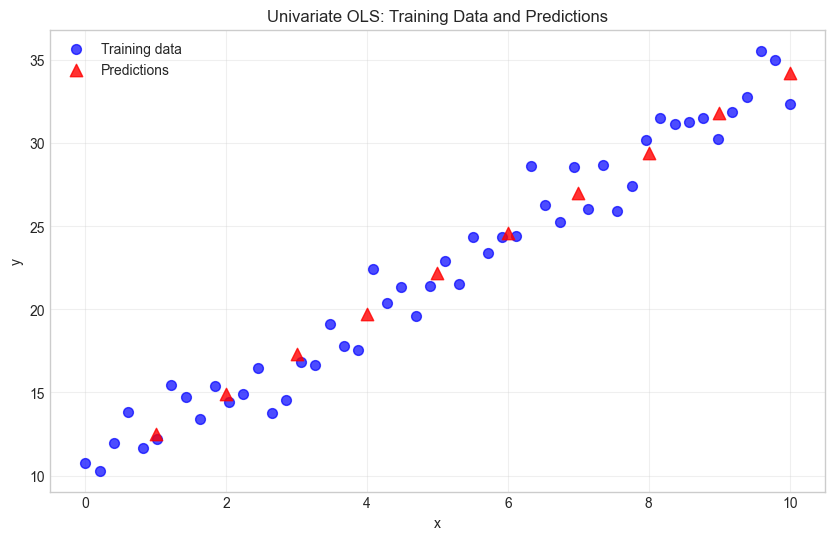

In [18]:
# Visualize the prediction
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, label='Training data', color='blue', s=50)
plt.scatter(x_new, y_new_pred, alpha=0.8, label='Predictions', color='red', s=80, marker='^')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Univariate OLS: Training Data and Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Recap — first OOP object

- Stores training data and configuration
- Fits parameters with closed-form OLS
- Predicts on new inputs
- Provides a simple reusable `UnivariateOLS` workflow

## Part 4 — RMSE metric

- Compute Root Mean Squared Error (RMSE) to quantify fit quality:

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

- Inputs: true values $y_i$, predictions $\hat{y}_i$, sample size $n$

### Why inheritance (not copy/paste)?

- Extend functionality cleanly by subclassing `UnivariateOLS`.

## Part 5 — Inheritance to extend functionality

- Subclass `UnivariateOLS` and add `compute_rmse`

- Reuse: data management (`__init__`), fit (`fit`), predict (`predict`)

- Benefits: avoid duplication, override selectively, focus on changes

- This is pretty helpful if you want to build upon an existing class: for example, if you want to build an enhanced version of the random forest model from sklearn, you don't need to start from scratch by copying and pasting the code.

- Instead, you can inherit from the existing class and add the new functionality or override the existing functionality.

- Inheritance is a powerful feature of OOP that allows you **focus on the changes** rather than the entire codebase.

In [19]:
class UnivariateOLSwithRMSE(UnivariateOLS):  # <-- Inherits from the UnivariateOLS class, put the "parent class" in the parentheses.
    # Multiple parent classes are possible, but we will not cover that in this course.
    def __init__(self, x_data: List[float], y_data: List[float], fit_intercept: bool=True) -> None:
        # The updated __init__ method calls the parent class's __init__ method so we don't
        # You can access the parent class's attributes and methods using the super() function.
        # We call the parent class's __init__ method to initialize the attributes of the parent class.
        super().__init__(x_data, y_data, fit_intercept)

        # after calling the parent class's __init__ method, we now have self.slope and self.intercept even though we did not define them in the UnivariateOLSwithRMSE.__init__ method.
        print(f"After calling the parent class's __init__ method, the slope is {self.slope} and the intercept is {self.intercept}.")

    def compute_rmse(self, x_data: List[float], y_data: List[float]) -> float:
        # This is the new functionality that we want to add.
        # It computes the RMSE of the model
        squared_errors = []
        # Note: we can use the parent class's method (i.e., self.predict) in this class even though we did not define it here.
        predictions = self.predict(x_data)

        # Note: there are much faster and more elegant ways to compute the RMSE using for example numpy (next quarter).
        # But let's stick to the basics for now.
        # Loop through each data point to calculate squared errors
        for i in range(len(y_data)):
            # Calculate the squared difference between actual and predicted values
            squared_error = (y_data[i] - predictions[i]) ** 2
            squared_errors.append(squared_error)

        # Calculate the mean of all squared errors
        mean_squared_error = sum(squared_errors) / len(squared_errors)

        # Return the square root of the mean squared error (RMSE)
        return np.sqrt(mean_squared_error)

    # We can also override the parent class's methods, we can print out the training set RMSE after fitting the model.
    def fit(self) -> None:
        # We call the parent class's fit method to fit the model as usual.
        super().fit()
        # This new method also reports the training set RMSE.
        print(f"The training set RMSE is {self.compute_rmse(self.x_data, self.y_data)}")

In [20]:
model = UnivariateOLSwithRMSE(x_data=x, y_data=y, fit_intercept=True)

After calling the parent class's __init__ method, the slope is None and the intercept is None.


In [21]:
model.fit()

Training data: n=50, Sx=250.0, Sy=1108.0894571057895, Sxx=1683.6734693877552, Sxy=6586.912165961563
Model intercept and slope have been fitted successfully.
The training set RMSE is 1.3625597377730294


In [22]:
# Suppose that we have a new set of observations.
x_new = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y_new = [12.3, 14.1, 15.8, 17.2, 25.5, 23.1, 25.8, 29.2, 30.7, 36.1]
y_new_pred = model.predict(x_new)
print(f"The predicted y values for the new x values are: {y_new_pred=:}")

The predicted y values for the new x values are: y_new_pred=[12.50968953906672, 14.922714439828988, 17.335739340591257, 19.748764241353523, 22.16178914211579, 24.57481404287806, 26.987838943640327, 29.400863844402593, 31.81388874516486, 34.22691364592713]


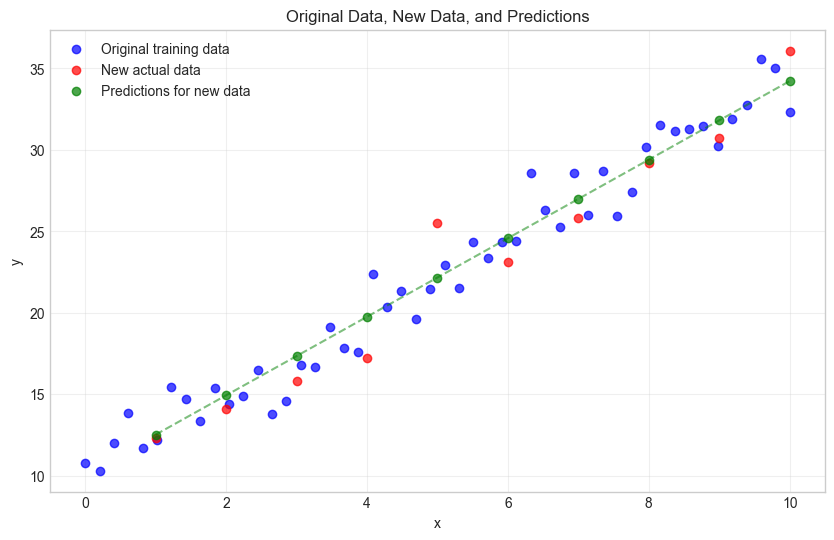

In [23]:
# Visualize the original data, new data, and predictions
plt.figure(figsize=(10, 6))

# Plot original training data
plt.scatter(x, y, color='blue', alpha=0.7, label='Original training data')

# Plot new actual data points
plt.scatter(x_new, y_new, color='red', alpha=0.7, label='New actual data')

# Plot predictions for new data
plt.scatter(x_new, y_new_pred, color='green', alpha=0.7, label='Predictions for new data')

# Add a line connecting predictions to show the trend
plt.plot(x_new, y_new_pred, color='green', linestyle='--', alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Original Data, New Data, and Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [24]:
# We can compute how good the model fits on the new set of data.
model.compute_rmse(x_new, y_new)

np.float64(1.7057186078524584)

## Part 6 — Special methods

- Integrate objects with Python syntax and printing (`__repr__`, `__str__`)

In [25]:
# As mentioned, we can use the `print` function to print any object.
# But since this is a customized class we just built, the `print` function will not be able to print it in an informative way.
# It only tells the class name and the memory address of the object.
print(model)

In [26]:
str(model)

'<__main__.UnivariateOLSwithRMSE object at 0x10f89f0e0>'

In [27]:
repr(model)

'<__main__.UnivariateOLSwithRMSE object at 0x10f89f0e0>'

### Difference between `__str__` and `__repr__`

#### Intended Audience
- `__str__` 
    - Designed for **end users**. Its goal is to return a string that is readable and friendly — something you’d want to show in logs or a user interface.
    - Called by the built-in `str()` function and by `print(obj)`.
- `__repr__`
    - Designed for **developers / debugging**. It should return an unambiguous string representation of the object — ideally one that could be used to recreate the object if passed to `eval()` (when practical).
    - Called by the built-in `repr()` function and used by the interactive interpreter when you type an object at the prompt.

#### Fallback Behavior
- If you define only `__repr__` but not `__str__`, Python will use `__repr__` when you call `str(obj)` or `print(obj)`.
- If you define only `__str__`, the interpreter will still use the default `__repr__` for the console/debug display.


#### Conclusion
- In this course, we are both the developer and the end user. I will be defining `__repr__` here because it updates the `__str__` method as well.

### What information to include in the representation string?

A few helpful pieces of information to include:
- What the model is for (e.g., "OLS model with intercept" or "OLS model without intercept")?
- Whether the model has been fitted or not?
- Some summary statistics for the training data (e.g., number of data points, mean of x, mean of y, etc.)
- The fitted parameters (slope and intercept) if available.
- A human-readable equation representation perhaps?
- For debugging: the class name and memory address (keep it for debugging purposes)

Sample:
```text
# Before fitting:
UnivariateOLS(not fitted)
UnivariateOLS(fit_intercept=True, slope_=None, intercept_=None)

# After fitting:
y ≈ 2.000 + 1.500 x
UnivariateOLS(fit_intercept=True, slope_=1.5, intercept_=2.0)
````

In [28]:
# We don't need to rewrite everything, instead, we inherit from the `UnivariateOLS` class and override the `__str__` and `__repr__` methods.

class UnivariateOLSwithSummary(UnivariateOLS):
    def __repr__(self) -> str:
        representation_string = f"UnivariateOLSwithSummary"
        if self.fit_intercept:
            representation_string += "\n - Estimated with intercept"
        else:
            representation_string += "\n - Estimated without intercept (i.e., fitted through the origin)"

        # Add summary statistics of the data.
        representation_string += f"\n - Data summary: {len(self.x_data)} data points, mean of x={sum(self.x_data)/len(self.x_data):.3f}, mean of y={sum(self.y_data)/len(self.y_data):.3f}."
        # Add range of x and y.
        representation_string += f"\n - Data range: x in [{min(self.x_data):.3f}, {max(self.x_data):.3f}], y in [{min(self.y_data):.3f}, {max(self.y_data):.3f}]."
        # You can even add an ascii art plot of the data (less useful lol...)
        representation_string += f"\n - Data plot for the training data: \n"
        # Create a simple ASCII plot
        plot_width = 40
        plot_height = 8

        # Get data ranges for scaling
        x_min, x_max = min(self.x_data), max(self.x_data)
        y_min, y_max = min(self.y_data), max(self.y_data)

        # Create empty plot canvas
        canvas = [[' ' for _ in range(plot_width)] for _ in range(plot_height)]
        # Plot the first 100 data points.
        for i in range(min(100, len(self.x_data))):
            # Scale coordinates to canvas size
            if x_max != x_min:
                x_pos = int((self.x_data[i] - x_min) / (x_max - x_min) * (plot_width - 1))
            else:
                x_pos = plot_width // 2

            if y_max != y_min:
                y_pos = plot_height - 1 - int((self.y_data[i] - y_min) / (y_max - y_min) * (plot_height - 1))
            else:
                y_pos = plot_height // 2

            # Place point on canvas
            if 0 <= x_pos < plot_width and 0 <= y_pos < plot_height:
                canvas[y_pos][x_pos] = '*'

        # Convert canvas to string with axes
        for i, row in enumerate(canvas):
            # Add y-axis labels on the left
            if i == 0:
                y_label = f"{y_max:.1f}"
            elif i == plot_height - 1:
                y_label = f"{y_min:.1f}"
            else:
                y_label = " " * 4

            representation_string += f"   {y_label:>4}|" + "".join(row) + "\n"

        # Add x-axis
        representation_string += "   " + " " * 4 + "+" + "-" * plot_width + "\n"
        representation_string += f"   {' ' * 4} {x_min:.1f}" + " " * (plot_width - 8) + f"{x_max:.1f}\n"

        # Add the fitted parameters if the model has been fitted.
        if self.slope is None:
            # the model has not been fitted yet
            representation_string += "\n - Not fitted, call `fit` method to fit the model before using it."
        else:
            # the model has been fitted
            if self.fit_intercept:
                representation_string += f"\n - Fitted (slope={self.slope:.3f}, intercept={self.intercept:.3f})."
            else:
                representation_string += f"\n - Fitted (slope={self.slope:.3f}, fitted through the origin). "

        # finally, the __repr__ method returns the string representation of the model.
        return representation_string

In [29]:
model = UnivariateOLSwithSummary(x_data=x_data, y_data=y_data, fit_intercept=True)

In [30]:
str(model)

'UnivariateOLSwithSummary\n - Estimated with intercept\n - Data summary: 50 data points, mean of x=5.000, mean of y=22.162.\n - Data range: x in [0.000, 10.000], y in [10.303, 35.565].\n - Data plot for the trainig data: \n   35.6|                                     *  \n       |                                    * **\n       |                        *  **  *****    \n       |                         *** **         \n       |               * * *****                \n       |             **** *                     \n       |    ** *** **                           \n   10.3|****  *   *                             \n       +----------------------------------------\n        0.0                                10.0\n\n - Not fitted, call `fit` method to fit the model before using it.'

In [31]:
repr(model)

'UnivariateOLSwithSummary\n - Estimated with intercept\n - Data summary: 50 data points, mean of x=5.000, mean of y=22.162.\n - Data range: x in [0.000, 10.000], y in [10.303, 35.565].\n - Data plot for the trainig data: \n   35.6|                                     *  \n       |                                    * **\n       |                        *  **  *****    \n       |                         *** **         \n       |               * * *****                \n       |             **** *                     \n       |    ** *** **                           \n   10.3|****  *   *                             \n       +----------------------------------------\n        0.0                                10.0\n\n - Not fitted, call `fit` method to fit the model before using it.'

In [32]:
print(model)

UnivariateOLSwithSummary
 - Estimated with intercept
 - Data summary: 50 data points, mean of x=5.000, mean of y=22.162.
 - Data range: x in [0.000, 10.000], y in [10.303, 35.565].
 - Data plot for the trainig data: 
   35.6|                                     *  
       |                                    * **
       |                        *  **  *****    
       |                         *** **         
       |               * * *****                
       |             **** *                     
       |    ** *** **                           
   10.3|****  *   *                             
       +----------------------------------------
        0.0                                10.0

 - Not fitted, call `fit` method to fit the model before using it.


In [33]:
# The model changes after fitting.
model.fit()
print(model)

Training data: n=50, Sx=250.0, Sy=1108.0894571057895, Sxx=1683.6734693877552, Sxy=6586.912165961563
Model intercept and slope have been fitted successfully.
UnivariateOLSwithSummary
 - Estimated with intercept
 - Data summary: 50 data points, mean of x=5.000, mean of y=22.162.
 - Data range: x in [0.000, 10.000], y in [10.303, 35.565].
 - Data plot for the trainig data: 
   35.6|                                     *  
       |                                    * **
       |                        *  **  *****    
       |                         *** **         
       |               * * *****                
       |             **** *                     
       |    ** *** **                           
   10.3|****  *   *                             
       +----------------------------------------
        0.0                                10.0

 - Fitted (slope=2.413, intercept=10.097).


## Bonus — Streaming/online OLS with `+=` and `+`

- Motivation: update models incrementally as new data arrive
- Overload `__iadd__` (for `+=`) and `__add__` (for `+`) to append data and refit
- Demonstrates: custom behavior for built-in operators
- Under the hood: `a + b` calls `a.__add__(b)`, `a += b` calls `a.__iadd__(b)`
- Contract: accept addable data and return the updated object

### Our addition semantics

- Adding a tuple `(x, y)` appends one training pair and refits

In [34]:
class UnivariateOnlineOLS(UnivariateOLSwithSummary):
    def __iadd__(self, new_data: Tuple[float, float]) -> "UnivariateOnlineOLS":
        self.x_data.append(new_data[0])
        self.y_data.append(new_data[1])
        # refit the model with the new data.
        self.fit()
        # return the modified object.
        return self

    def __add__(self, new_data: Tuple[float, float]) -> "UnivariateOnlineOLS":
        # we can reuse the __iadd__ method to add the new data.
        return self.__iadd__(new_data)

In [35]:
# let's see how it works..
model = UnivariateOnlineOLS(x_data=x_data, y_data=y_data, fit_intercept=True)
model.fit()
print(model)

Training data: n=50, Sx=250.0, Sy=1108.0894571057895, Sxx=1683.6734693877552, Sxy=6586.912165961563
Model intercept and slope have been fitted successfully.
UnivariateOLSwithSummary
 - Estimated with intercept
 - Data summary: 50 data points, mean of x=5.000, mean of y=22.162.
 - Data range: x in [0.000, 10.000], y in [10.303, 35.565].
 - Data plot for the trainig data: 
   35.6|                                     *  
       |                                    * **
       |                        *  **  *****    
       |                         *** **         
       |               * * *****                
       |             **** *                     
       |    ** *** **                           
   10.3|****  *   *                             
       +----------------------------------------
        0.0                                10.0

 - Fitted (slope=2.413, intercept=10.097).


In [36]:
# Add a new pair of data points to the model.
# See how the summary statistics and the fitted line change.
model = model + (15, 5)
print(model)

Training data: n=51, Sx=265.0, Sy=1113.0894571057895, Sxx=1908.6734693877552, Sxy=6661.912165961563
Model intercept and slope have been fitted successfully.
UnivariateOLSwithSummary
 - Estimated with intercept
 - Data summary: 51 data points, mean of x=5.196, mean of y=21.825.
 - Data range: x in [0.000, 15.000], y in [5.000, 35.565].
 - Data plot for the trainig data: 
   35.6|                        *               
       |                     ******             
       |                * **** *                
       |             *******                    
       |         *****                          
       | * ********                             
       |*** *                                   
    5.0|                                       *
       +----------------------------------------
        0.0                                15.0

 - Fitted (slope=1.652, intercept=13.243).


In [37]:
model += (20, 3)
print(model)

Training data: n=52, Sx=285.0, Sy=1116.0894571057895, Sxx=2308.673469387755, Sxy=6721.912165961563
Model intercept and slope have been fitted successfully.
UnivariateOLSwithSummary
 - Estimated with intercept
 - Data summary: 52 data points, mean of x=5.481, mean of y=21.463.
 - Data range: x in [0.000, 20.000], y in [3.000, 35.565].
 - Data plot for the trainig data: 
   35.6|                  *                     
       |               *****                    
       |            **** *                      
       |       * *** **                         
       |      *****                             
       | ******                                 
       |**                                      
    3.0|                             *         *
       +----------------------------------------
        0.0                                20.0

 - Fitted (slope=0.810, intercept=17.023).


In [38]:
new_data_pairs = [(15, 5), (20, 3), (25, 2), (30, 1), (35, 0.5), (40, 0.25), (45, 0.1), (50, 0.05), (55, 0.025), (60, 0.01)]

model = UnivariateOnlineOLS(x_data=x_data, y_data=y_data, fit_intercept=True)
model.fit()
# add them one by one and see how the model changes.
fitted_slopes = [model.slope]
fitted_intercepts = [model.intercept]
for pair in new_data_pairs:
    model += pair
    fitted_slopes.append(model.slope)
    fitted_intercepts.append(model.intercept)

Training data: n=50, Sx=250.0, Sy=1108.0894571057895, Sxx=1683.6734693877552, Sxy=6586.912165961563
Model intercept and slope have been fitted successfully.
Training data: n=51, Sx=265.0, Sy=1113.0894571057895, Sxx=1908.6734693877552, Sxy=6661.912165961563
Model intercept and slope have been fitted successfully.
Training data: n=52, Sx=285.0, Sy=1116.0894571057895, Sxx=2308.673469387755, Sxy=6721.912165961563
Model intercept and slope have been fitted successfully.
Training data: n=53, Sx=310.0, Sy=1118.0894571057895, Sxx=2933.673469387755, Sxy=6771.912165961563
Model intercept and slope have been fitted successfully.
Training data: n=54, Sx=340.0, Sy=1119.0894571057895, Sxx=3833.673469387755, Sxy=6801.912165961563
Model intercept and slope have been fitted successfully.
Training data: n=55, Sx=375.0, Sy=1119.5894571057895, Sxx=5058.673469387755, Sxy=6819.412165961563
Model intercept and slope have been fitted successfully.
Training data: n=56, Sx=415.0, Sy=1119.8394571057895, Sxx=6658

Training data: n=50, Sx=250.0, Sy=1108.0894571057895, Sxx=1683.6734693877552, Sxy=6586.912165961563
Model intercept and slope have been fitted successfully.


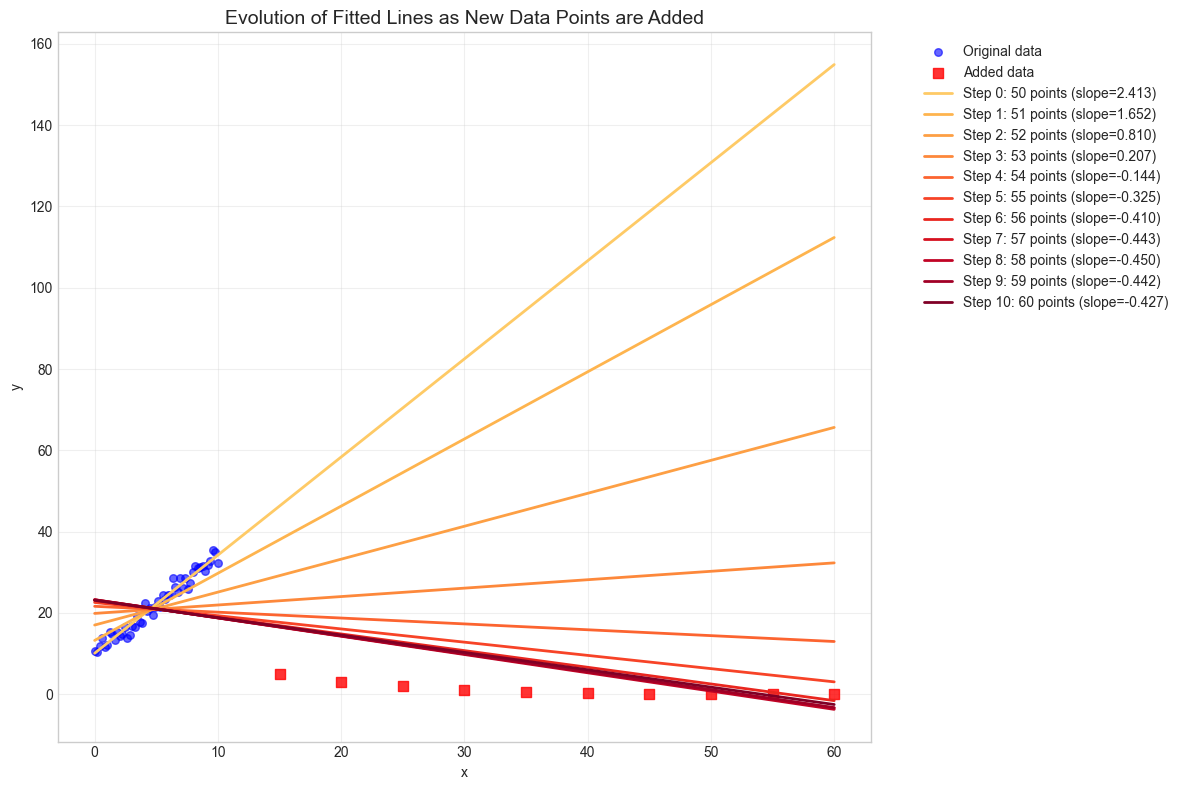

In [39]:
# plot the evolution of fitted lines as new data points are added
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create initial model to get x_data range
temp_model = UnivariateOnlineOLS(x_data=x_data, y_data=y_data, fit_intercept=True)
temp_model.fit()

# Plot original data points
ax.scatter(x_data, y_data, color='blue', alpha=0.6, s=30, label='Original data')

# Plot all added data points
all_added_x = [pair[0] for pair in new_data_pairs]
all_added_y = [pair[1] for pair in new_data_pairs]
ax.scatter(all_added_x, all_added_y, color='red', alpha=0.8, s=50, marker='s', label='Added data')

# Get overall x range for all data
all_x = list(x_data) + all_added_x
x_min, x_max = min(all_x), max(all_x)
x_range = np.linspace(x_min, x_max, 100)

# Create color map from yellow to dark red
colors = plt.cm.YlOrRd(np.linspace(0.3, 1.0, len(fitted_slopes)))

# Plot each fitted line with different colors (yellow to dark red)
for i in range(len(fitted_slopes)):
    y_pred = fitted_slopes[i] * x_range + fitted_intercepts[i]
    data_points = len(x_data) + i
    ax.plot(x_range, y_pred, color=colors[i], linewidth=2,
            label=f'Step {i}: {data_points} points (slope={fitted_slopes[i]:.3f})')

ax.set_title('Evolution of Fitted Lines as New Data Points are Added', fontsize=14)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Attendance code? See the whiteboard.

## Key takeaways and references

- Encapsulation: store data/params on objects
- Methods: `fit`, `predict` operate on state
- Extensibility: subclass to add metrics/features
- Special methods: make objects pleasant to use/print

References:
- Course site: [CME 193 — Scientific Python](https://tianyudu.github.io/CME193-Autumn-2025/)
- 📖 Real Python OOP guide: `https://realpython.com/python3-object-oriented-programming/`
- 💻 Companion Colab notebook (previous quarter): `https://colab.research.google.com/drive/1lElGzDa_uOUNB2YeZ8h92QCCuCRR2esm?usp=sharing`